# **Treinamento Tarefas Dia a Dia de um DBA**

- Carlos Eduardo Gimenes
- Last Modified: January, 2024

> **Copyright (C) 2023 Carlos Eduardo Gimenes**  
> All rights reserved.  
> You may alter this code for your own _non-commercial_ purposes.  
> You may republish altered code as long as you include this copyright and give due credit.
> 
> THIS CODE AND INFORMATION ARE PROVIDED "AS IS" WITHOUT WARRANTY OF ANY KIND, EITHER EXPRESSED OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE IMPLIED WARRANTIES OF MERCHANTABILITY AND/OR FITNESS FOR A PARTICULAR PURPOSE.

# **Check SQL Server version**

- **Approach 1:**

In [ ]:
SELECT
    SERVERPROPERTY('productversion') AS ProductVersion,
    SERVERPROPERTY('productlevel') AS ProductLevel,
    SERVERPROPERTY('edition') AS Edition

- **Approach 2:**

In [ ]:
SELECT
    @@VERSION AS Version

# **Check The current version of the installed Service Pack**

In [ ]:
SELECT
    @@VERSION

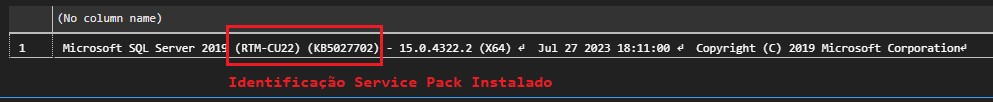

# **Check and adjust Error Log configuration**

- **SQL Server running in Linux**
    - Via Managment Studio, clique com o botão direito na Instancia, em seguida em Facets, em Facet procure por Server Settings e em Facet properties, procure por NumberOfLogFiles e defina o número de arquivos que deseja manter

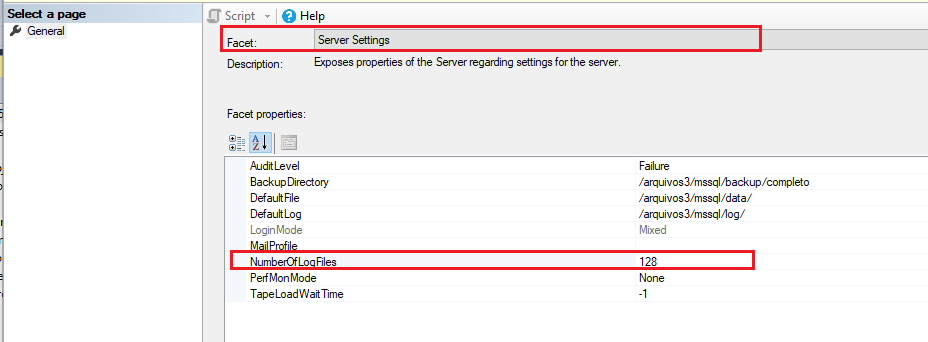

- **SQL Server running in Windows**
    - Via Managment Studio, vá em Managment e clique com o botão direito em SQL Server Logs, em seguida em Configure e marque a opção Limit the number of error log files before they are recycled e em Maximum number of error log files, defina o número de arquivos que deseja manter
    - Via T-SQL ajuste e execute o script abaixo

In [ ]:
USE master
GO

EXEC xp_instance_regwrite N'HKEY_LOCAL_MACHINE', N'Sotware\Microsoft\MSSQLServer\MSSQLServer', N'NumErrorLogs', REG_DWORD, InformarNumeroDesejado

# **Collation Tests**

### 

- **Check Instance Collation information**

In [ ]:
-- Retorna Collation da Instancia
SELECT
    SERVERPROPERTY(N'Collation') SQLInstanceCollation

### 

- **Check Database Collation information**

In [ ]:
-- Retorna Collation do Database
SELECT
    DATABASEPROPERTYEX('SampleDB', 'Collation') SQLDatabaseCollation        -- Ajuste o nome do Database, neste exemplo checamos para o Database SampleDB

### 

- **Creating a Database called "TesteCollation" with a Collation different from the Server: "Latin1\_General\_CI\_AI"**

In [ ]:
-- Create Database named TesteCollation

IF EXISTS(SELECT name FROM sys.databases WHERE name = 'TesteCollation')
    DROP DATABASE TesteCollation

CREATE DATABASE [TesteCollation]
    ON PRIMARY
    ( NAME = N'TesteCollation',
    FILENAME = N'/arquivos3/mssql/data/TesteCollation.mdf',
    SIZE = 5120KB, FILEGROWTH = 1024KB )
    LOG ON
    ( NAME = N'TesteCollation_log',
    FILENAME = N'/arquivos3/mssql/log/TesteCollation_log.ldf',
    SIZE = 1024KB, FILEGROWTH = 10%)
    COLLATE Latin1_General_CI_AS

### 

- **Checking that the Collation of the Database and the Server are different**

In [ ]:
-- Collation do Database criado
SELECT
    DATABASEPROPERTYEX('TesteCollation', 'Collation') SQLDatabaseCollation

-- Collation do Servidor
SELECT
    SERVERPROPERTY(N'Collation') SQLServerCollation

### 

- **Check ALL Database Collation information**

In [ ]:
-- Collation de TODOS Databases
SELECT
    name,
    collation_name
FROM
    sys.databases
ORDER BY
    name

### 

- **Criando uma tabela no Database TesteCollation e uma tabela Temporária para simular o problema gerado com Collations diferentes**

In [ ]:
/*
USE TesteCollation
DROP TABLE Cliente
GO

USE tempdb
DROP TABLE #Cliente2
GO
*/

USE TesteCollation
GO
CREATE TABLE Cliente(Cod int identity, Nome VARCHAR(50))

INSERT INTO Cliente
SELECT 'Carlos Eduardo Gimenes'

CREATE TABLE #Cliente2(Cod int identity, Nome VARCHAR(50))

INSERT INTO #Cliente2
SELECT 'Carlos Eduardo Gimenes'


### 

- **Realizando um Join entre uma tabela Temporária e uma tabela da base de dados TesteCollation**

In [ ]:
SELECT *
FROM #Cliente2 A
JOIN Cliente B ON A.Nome = B.Nome

-- Recebemos o seguinte erro:
/*
Msg 468, Level 16, State 9, Line 3
Cannot resolve the collation conflict between "Latin1_General_CI_AS" and "Latin1_General_CI_AI" in the equal to operation.
Total execution time: 00:00:00.003
*/

### 

- **Como resolver o erro reportado na consulta anterior**

In [ ]:
SELECT *
FROM #Cliente2 A
JOIN Cliente B ON A.nome COLLATE Latin1_General_CI_AI = B.nome

/*
Colocando o camando "COLLATE Latin1_General_CI_AI" convertemos o resultado da coluna A.nome para a Collation "Latin1_General_CI_AI"
que é igual aquela utilizada na coluna da base
*/

### 

- **Excluindo Database utilizado na Demo**

In [ ]:
USE master
DROP DATABASE TesteCollation
GO

USE tempdb
DROP TABLE #Cliente2
GO

### 

- **Curiosidade: conversão para retirar todos os acentos de uma String**

In [ ]:
Declare @cExpressao varchar(30)

Set @cExpressao = 'aeiouáéíóúàèìòòâêîôûãõäëïöüç'

Select
    @cExpressao ANTES,
    @cExpressao collate sql_latin1_general_cp1251_ci_as DEPOIS

- **Collation pode impactar na PERFORMANCE?**
    - [Veja maiores explicações neste vídeo](https:\www.fabriciolima.net\blog\2017\02\06\video-melhorando-a-performance-de-uma-consulta-com-like-string-alterando-a-collation\)

In [ ]:
-- Criar Tabela
/*
DROP TABLE IF EXISTS dbo.Teste_Collation_SQL

CREATE TABLE dbo.Teste_Collation_SQL (
    cod int IDENTITY(1,1) PRIMARY KEY,
    Dt_Log DATETIME,
    Descricao VARCHAR(50)
)
*/

-- Popular Tabela (Processo pode demorar alguns minutos)
-- Insert rows into table 'TableName' in schema '[dbo]'
/*
INSERT INTO [dbo].[Teste_Collation_SQL]
SELECT GETDATE(), REPLICATE('A', 50)
GO 10
*/

/*
INSERT INTO dbo.Teste_Collation_SQL
SELECT Dt_Log, Descricao
FROM Teste_Collation_SQL
GO 18
*/


/*
INSERT INTO dbo.Teste_Collation_SQL
SELECT GETDATE(), 'Carlos Eduardo Gimenes 1'
*/

/*
INSERT INTO dbo.Teste_Collation_SQL
SELECT GETDATE(), '- Carlos Eduardo Gimenes 2'
*/


--CREATE NONCLUSTERED INDEX SK01_Teste_Collation_SQL ON Teste_Collation_SQL(Descricao) WITH (FILLFACTOR=95)

EXEC sp_spaceused Teste_Collation_SQL

/*
SET STATISTICS IO ON
SET STATISTICS TIME ON
*/
-- CTRL+M

-- Teste 1 Usando a Collation da coluna: Latin1_General_CI_AI
/*
SELECT COUNT(*)
FROM TreinamentoDBA.dbo.Teste_Collation_SQL
WHERE Descricao LIKE '%Carlos%'
*/

-- Consumo CPU


-- Teste 2 Usando a Collation da coluna: Latin1_General_CI_AI
/*
SELECT COUNT(*)
FROM TreinamentoDBA..Teste_Collation_SQL
WHERE Descricao COLLATE SQL_Latin1_General_CP1_CI_AI LIKE '%Carlos%'
*/

-- Rodando o Teste 1 forcando a Collation da coluna (que nao faz diferenca nenhuma)
/*
SELECT COUNT(*)
FROM TreinamentoDBA..Teste_Collation_SQL
WHERE Descricao COLLATE Latin1_General_CI_AI LIKE '%Carlos%'
*/

/* =======================================================================================================

Curiosidade: A Collation BIN é ainda mais rapida, contudo ela e CASE SENSITIVE e ACENT SENSITIVE
Se voce tivesse uma Collation Latin1_General_CS_AS, poderia fazer o like com a Latin1_General1_BIN2

========================================================================================================*/

/*
SELECT COUNT(*)
FROM TreinamentoDBA..Teste_Collation_SQL
WHERE Descricao COLLATE Latin1_General_BIN2 LIKE '%Carlos%'
*/

/* =======================================================================================================

Link com referencia explicando um pouco do motivo disso acontecer:
https://support.microsoft.com/en-us/help/322112/comparing-sql-collations-to-windows-collations

Obs.: Se usar uma coluna Nvarchar ao inves de varchar, isso nao acontece, o tempo e o mesmo

========================================================================================================*/
